# The Model class

As we saw in previous tutorials GemyPy relies in several classes for its data structure. The problem of this is that most of this classes are entangled with each other. To deal with this in the new version of GemPy we have created many methods to map and upsdate data from an object to other. However, calling these methods every time one of the object is modified can get extremely verbose every time. To deal with this we create the `Model` class. This class have two main goals:

1. Deal with the mapping updating logic automatically and in a lightweight way.
2. Add specific functionality relevant to the model as a whole.

In this notebook we will go through many of of this methods:

In [3]:
# These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../..")

# Importing GemPy
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing auxiliary libraries
import numpy as np
import pandas as pn
import matplotlib.pyplot as plt



The description of the methods nomenclature remains the same as for the `data.py` module with the particularity that update is splitted in:

- *update_from*
    - update current object with the rest of dependencies. This is useful if you change an object and you want to update the fields with the rest of the objects. E.g after a set_surface_points
    
- *update_to*
    - update dataframes from the current object. This is useful if you modify one of the model dependencies and you want to update all the other dependecies
    
When we initialize a `Model` class we create all the necessary objects already entangled with each other.

In [4]:
model = gp.Model()

As expected these dependencies are empty:

In [5]:
model.surface_points

,X,Y,Z,X_r,Y_r,Z_r,surface,series,id,order_series


In [6]:
model.surfaces

,surface,series,order_surfaces,isBasement,color,id


In [7]:
model.series

,order_series,BottomRelation
Default series,1,Erosion


The pandas DataFrames are already configurated properly to categories:

In [8]:
model.surfaces.df['series'], model.surfaces.df['surface'] 

(Series([], Name: series, dtype: category
 Categories (1, object): [Default series]),
 Series([], Name: surface, dtype: object))

And additional data has everything pretty much empty:

In [9]:
model.additional_data

values
Structure isLith                                  True
          isFault                                False
          number faults                              0
          number surfaces                            0
          number series                              1
          number surfaces per series                []
          len surfaces surface_points               []
          len series surface_points                [0]
          len series orientations                   []
Options   dtype                                float64
          output                               geology
          theano_optimizer                fast_compile
          device                                   cpu
          verbosity                                 []
Kriging   range                                      0
          $C_o$                                      0
          drift equations                          [0]
          nugget grad                             0.01
          nugget scalar                          1e-06
Rescaling rescaling factor                         NaN
          centers                      [nan, nan, nan]

## Reading data

Usually data will be imported from external files. GemPy uses `pandas.read_table` powerful functionality for that. The default format is XYZ surface_name: 

In [11]:
model.read_data(path_i=os.pardir+"/data/input_data/tut_chapter1/simple_fault_model_points.csv",
                path_o=os.pardir+"/data/input_data/tut_chapter1/simple_fault_model_orientations.csv")

In [9]:
model.orientations

,X,Y,Z,X_r,Y_r,Z_r,G_x,G_y,G_z,dip,azimuth,polarity,surface,series,id,order_series
0,1000,1000,950.000,0.539574,0.5001,0.513258,0.316229,1.000019e-12,0.948683,18.435,90.0,1.0,Shale,Default series,NaN,1
1,400,1000,1400.000,0.381679,0.5001,0.631679,0.316229,1.000019e-12,0.948683,18.435,90.0,1.0,Sandstone_2,Default series,NaN,1
2,500,1000,864.602,0.407995,0.5001,0.490785,-0.948683,9.998257e-13,0.316229,71.565,270.0,1.0,Main_Fault,Default series,NaN,1


In [10]:
a = model.surfaces.df['series'].cat
a.set_categories(model.series.df.index)

0    Default series
1    Default series
2    Default series
3    Default series
4    Default series
5    Default series
Name: series, dtype: category
Categories (1, object): [Default series]

In [14]:
model.map_series_to_surfaces({"Fault_Series":('Main_Fault', 'Silstone'), 
                               "Strat_Series": ( 'Sandstone_2', 'Sandstone_1', 'Siltstone',
                                             'Shale', )}, )

,surface,series,order_surfaces,isBasement,color,id
4,Main_Fault,Fault_Series,1,False,#443988,1
0,Shale,Strat_Series,1,False,#015482,2
1,Sandstone_1,Strat_Series,2,False,#9f0052,3
2,Siltstone,Strat_Series,3,False,#ffbe00,4
3,Sandstone_2,Strat_Series,4,False,#728f02,5
5,basement,Basement,1,True,#ff3f20,6


In [13]:
model.series

,order_series,BottomRelation
Fault_Series,1,Erosion
Strat_Series,2,Erosion


In [15]:
model.surfaces

,surface,series,order_surfaces,isBasement,id
5,basement,Default series,1,False,1
4,Main_Fault,Fault_Series,1,False,2
0,Shale,Strat_Series,1,False,3
1,Sandstone_1,Strat_Series,2,False,4
2,Siltstone,Strat_Series,3,False,5
3,Sandstone_2,Strat_Series,4,True,6


In [16]:
model.surface_points.df.head()

,X,Y,Z,X_r,Y_r,Z_r,surface,series,id,order_series
52,700,1000,900,0.460626,0.5001,0.500100,Main_Fault,Fault_Series,2,2
53,600,1000,600,0.434311,0.5001,0.421153,Main_Fault,Fault_Series,2,2
54,500,1000,300,0.407995,0.5001,0.342205,Main_Fault,Fault_Series,2,2
55,800,1000,1200,0.486942,0.5001,0.579047,Main_Fault,Fault_Series,2,2
56,900,1000,1500,0.513258,0.5001,0.657995,Main_Fault,Fault_Series,2,2


In [17]:
model.orientations.df.head()

,X,Y,Z,X_r,Y_r,Z_r,G_x,G_y,G_z,dip,azimuth,polarity,surface,series,id,order_series
2,500,1000,864.602,0.407995,0.5001,0.490785,-0.948683,9.998257e-13,0.316229,71.565,270.0,1.0,Main_Fault,Fault_Series,2,2
0,1000,1000,950.000,0.539574,0.5001,0.513258,0.316229,1.000019e-12,0.948683,18.435,90.0,1.0,Shale,Strat_Series,3,3
1,400,1000,1400.000,0.381679,0.5001,0.631679,0.316229,1.000019e-12,0.948683,18.435,90.0,1.0,Sandstone_2,Strat_Series,6,3


Next we need to categorize each surface into the right series. This will update all the Dataframes depending on `Formations` and `Series` to the right categories:

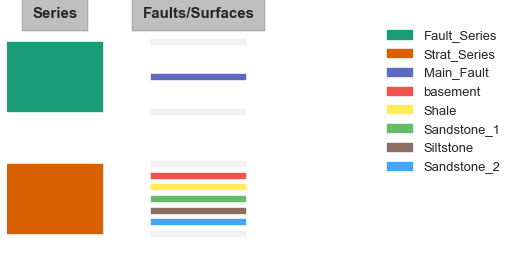

In [18]:
model.map_series_to_surfaces({"Fault_Series":'Main_Fault', 
                                "Strat_Series": ('Sandstone_2','Siltstone',
                                                 'Shale', 'Sandstone_1')})

In [19]:
model.surfaces.df['series']

4    Fault_Series
5    Strat_Series
0    Strat_Series
1    Strat_Series
2    Strat_Series
3    Strat_Series
Name: series, dtype: category
Categories (2, object): [Fault_Series, Strat_Series]

In [20]:
model.surfaces

,surface,series,order_surfaces,isBasement,id
4,Main_Fault,Fault_Series,1,False,1
5,basement,Strat_Series,1,False,2
0,Shale,Strat_Series,2,False,3
1,Sandstone_1,Strat_Series,3,False,4
2,Siltstone,Strat_Series,4,False,5
3,Sandstone_2,Strat_Series,5,True,6


In [21]:
model.surface_points.df.head()

,X,Y,Z,X_r,Y_r,Z_r,surface,series,id,order_series
52,700,1000,900,0.460626,0.5001,0.500100,Main_Fault,Fault_Series,1,1
53,600,1000,600,0.434311,0.5001,0.421153,Main_Fault,Fault_Series,1,1
54,500,1000,300,0.407995,0.5001,0.342205,Main_Fault,Fault_Series,1,1
55,800,1000,1200,0.486942,0.5001,0.579047,Main_Fault,Fault_Series,1,1
56,900,1000,1500,0.513258,0.5001,0.657995,Main_Fault,Fault_Series,1,1


In [22]:
model.series

,order_series,BottomRelation
Fault_Series,1,Erosion
Strat_Series,2,Erosion


In the case of having faults we need to assign wich series are faults:

In [23]:
model.faults

,isFault,isFinite
Fault_Series,False,False
Strat_Series,False,False


In [24]:
model.set_is_fault(['Fault_Series'])

Fault series: ['Fault_Series'] moved to the top of the pile.


,isFault,isFinite
Fault_Series,True,False
Strat_Series,False,False


In [25]:
model.surface_points.df.head()

,X,Y,Z,X_r,Y_r,Z_r,surface,series,id,order_series
52,700,1000,900,0.460626,0.5001,0.500100,Main_Fault,Fault_Series,1,1
53,600,1000,600,0.434311,0.5001,0.421153,Main_Fault,Fault_Series,1,1
54,500,1000,300,0.407995,0.5001,0.342205,Main_Fault,Fault_Series,1,1
55,800,1000,1200,0.486942,0.5001,0.579047,Main_Fault,Fault_Series,1,1
56,900,1000,1500,0.513258,0.5001,0.657995,Main_Fault,Fault_Series,1,1


Again as we can see, as long we use the model methods all the dependent objects change inplace accordingly. If for any reason you do not want this behaviour you can always use the individual methods of the objects (e.g. `model.faults.set_is_fault`)

In [26]:
model.additional_data

values
Structure isLith                                         True
          isFault                                        True
          number faults                                     1
          number surfaces                                   5
          number series                                     2
          number surfaces per series                   [1, 4]
          len surfaces surface_points      [5, 0, 16, 15, 13]
          len series surface_points                   [5, 52]
          len series orientations                      [1, 2]
Options   dtype                                       float64
          output                                      geology
          theano_optimizer                       fast_compile
          device                                          cpu
          verbosity                                        []
Kringing  range                                             0
          $C_o$                                             0
          drift equations                              [3, 3]
          nugget grad                                    0.01
          nugget scalar                                 1e-06
Rescaling rescaling factor                               3800
          centers                      [850.0, 1000.0, 900.0]

## Setting grid

So far we have worked on data that depends exclusively of input (i.e. sequeantial pile, surface_points, orientations, etc). With things like grid the idea is the same:

In [27]:
model.grid.values

array([[1.95132487e+227, 2.65106778e-258, 2.62785629e+092]])

In [28]:
model.set_regular_grid([0,10,0,10,0,10], [50,50,50])

## Getting data

Alternatively we can access the dataframe by:

In [30]:
gp.get_data(model, 'surfaces')

,surface,series,order_surfaces,isBasement,id
4,Main_Fault,Fault_Series,1,False,1
5,basement,Strat_Series,1,False,2
0,Shale,Strat_Series,2,False,3
1,Sandstone_1,Strat_Series,3,False,4
2,Siltstone,Strat_Series,4,False,5
3,Sandstone_2,Strat_Series,5,True,6


The class `gempy.core.model.Model` works as the parent container of our project. Therefore the main step of any project is to create an instance of this class. In the official documentation we use normally geo_model (geo_data in the past) as name of this instance.

When we instiantiate a `Model` object we full data structure is created. By using `gp.init_data` and `set_series` we set the default values -- given the attributes -- to all of fields. Data is stored in pandas dataframes. With `gp.get_data` and the name of the data object it is possible to have access to the dataframes: 

`str`['all', 'surface_points', 'orientations', 'formations', 'series', 'faults', 'faults_relations', 
        additional data]
        
These dataframes are stored in specific objects. These objects contain the specific methods to manipulate them. You access these objects with the spectific getter or as a attribute of `Model`